In [1]:
import numpy as np
from src.Simulator.SSA import SSASimulator
from src.Plotter.SystemPlotter import SysPlotter
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from src.Estimation.rnn import MultiRNNTrainer

2023-09-22 14:25:49.575543: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-22 14:25:49.577003: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-22 14:25:49.605000: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-22 14:25:49.605616: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-22 14:25:50.074457: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

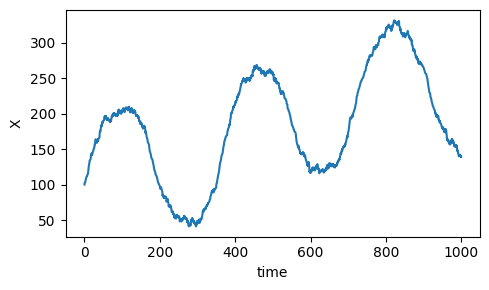

In [2]:
from src.Models.paper_examples import BirthDeathPaper
model_BD = BirthDeathPaper()
simulator_BD = SSASimulator(model_BD)

parameters_BD = model_BD.getDefaultParameter()
y, t = simulator_BD.run_ssa(np.array([100]), 1000, parameters_BD)

plotter = SysPlotter()
fig = plotter.plotSystem(y, t, model_BD)

In [3]:
scaler = StandardScaler()
y = scaler.fit_transform(y)

data = pd.DataFrame(data={'t': t, "y": y.reshape(-1)})

data['t_sin'] = np.sin(2 * np.pi * data.t)
data['t_cos'] = np.cos(2 * np.pi * data.t)
data = data.drop(columns=["t"])
data = data[["t_sin", 't_cos', "y"]]


train_data, test_data = train_test_split(data,test_size=0.5, shuffle=False)

In [4]:
train_data

,t_sin,t_cos,y
0,0.000000,1.000000,-1.104628
1,0.252186,0.967679,-1.091571
2,0.886973,0.461822,-1.078514
3,-0.934063,-0.357107,-1.065456
4,0.260797,0.965394,-1.052399
...,...,...,...
1277,-0.126333,-0.991988,0.919240
1278,-0.379284,-0.925280,0.932297
1279,-0.964888,-0.262662,0.919240
1280,0.891488,0.453045,0.906183


In [5]:
def split_window(features):
    input_slice = 6
    inputs = features[:, :input_slice, :]
    labels = features[:, input_slice-1:, -1:]
        
    return inputs, labels


def make_dataset(data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=6,
      sequence_stride=1,
      shuffle=False,
      batch_size=32,)
    
    ds = ds.map(split_window)
    
    return ds

train_generator = make_dataset(train_data)
test_generator = make_dataset(test_data)

2023-09-22 14:25:59.073071: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-09-22 14:25:59.073122: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: markphillip
2023-09-22 14:25:59.073126: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: markphillip
2023-09-22 14:25:59.073259: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.54.3
2023-09-22 14:25:59.073282: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: NOT_FOUND: could not find kernel module information in driver version file contents: "NVRM version: NVIDIA UNIX Open Kernel Module for x86_64  535.54.03  Release Build  (dvs-builder@U16-I2-C03-15-1)  Tue Jun  6 22:31:30 UTC 2023
GCC version:  gcc version 11.4.0 (Ubuntu 11.4.0-1ubuntu1~22.04) 
"


In [6]:
model = MultiRNNTrainer([train_generator])

[<_MapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float32, name=None))>]


In [8]:
model.datasets

<_MapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float32, name=None))>

In [7]:
model.train(epochs=10)

Epoch0---Loss--------0.25036513805389404
Epoch1---Loss--------0.031490758061409
Epoch2---Loss--------0.014919061213731766
Epoch3---Loss--------0.012932849116623402
Epoch4---Loss--------0.012627724558115005
Epoch5---Loss--------0.011405020952224731
Epoch6---Loss--------0.011502251960337162
Epoch7---Loss--------0.011099804192781448
Epoch8---Loss--------0.01118466630578041
Epoch9---Loss--------0.01109776645898819


In [9]:
pred = []
targ = []
for feat, target in test_generator:
    pred.append(np.array(model.models[0].predict(feat)))
    targ.append(np.array(target))
    
pred = np.vstack(pred)
targ = np.vstack(targ)

1/1 [==============================] - 0s 224ms/step


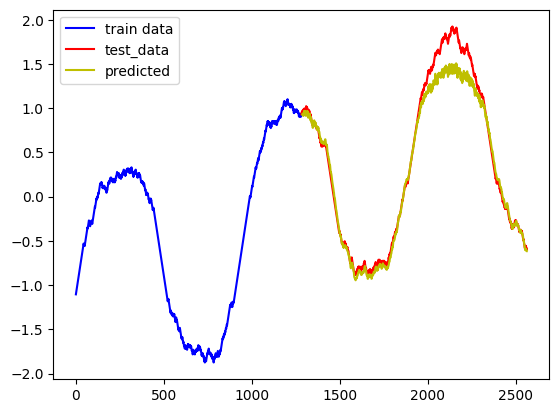

In [10]:
plt.plot(train_data.y, color='b', label="train data")
plt.plot(test_data.y, color='r', label="test_data")
plt.plot(test_data.index[5:],pred,color='y', label="predicted")
plt.legend()
plt.show()

In [11]:
from src.Models.paper_examples import ThreeSpeciesModel
model_LV = ThreeSpeciesModel()
simulator_LV = SSASimulator(model_LV)

In [12]:
parameters_LV = model_LV.getDefaultParameter()

y, t = simulator_LV.run_ssa(np.array([10**5,10,10]), 100, parameters_LV)

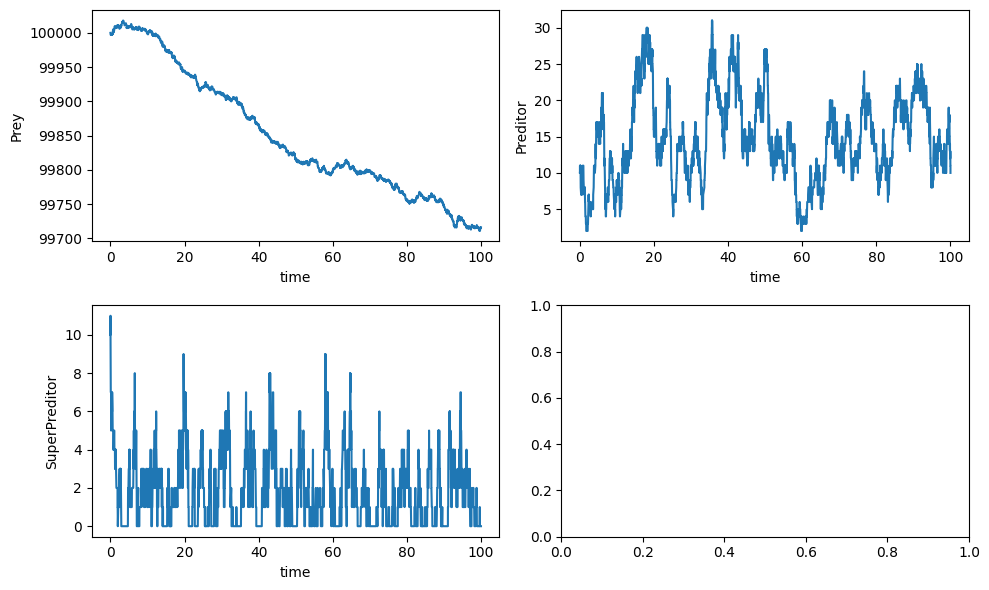

In [13]:
plotter = SysPlotter()
fig = plotter.plotSystem(y, t, model_LV)

In [14]:
data = pd.DataFrame(data = {"t": t, "y_0": y[:,0], "y_1": y[:,1], "y_2": y[:,2]})
data[["y_0", "y_1", "y_2"]] = scaler.fit_transform(data[["y_0", "y_1", "y_2"]])
species_0 = data[["t", "y_0"]]
species_1 = data[["t", "y_1"]]
species_2 = data[["t", "y_2"]]


species_0_test = species_0.loc[0.5*len(species_0):]
species_1_test = species_1.loc[0.6*len(species_1):]
species_2_test = species_2.loc[0.7*len(species_2):]

species_0_test['t_sin'] = np.sin(2 * np.pi * species_0_test.t)
species_0_test['t_cos'] = np.cos(2 * np.pi * species_0_test.t)
species_0_test = species_0_test[["t_sin", 't_cos', "y_0"]]

species_1_test['t_sin'] = np.sin(2 * np.pi * species_1_test.t)
species_1_test['t_cos'] = np.cos(2 * np.pi * species_1_test.t)
species_1_test = species_1_test[["t_sin", 't_cos', "y_1"]]


species_2_test['t_sin'] = np.sin(2 * np.pi * species_2_test.t)
species_2_test['t_cos'] = np.cos(2 * np.pi * species_2_test.t)
species_2_test = species_2_test[["t_sin", 't_cos', "y_2"]]





species_0 = species_0.loc[:0.5*len(species_0)]
species_1 = species_1.loc[0.2*len(species_1):0.6*len(species_1)]
species_2 = species_2.loc[0.4*len(species_2):0.7*len(species_2)]


species_0['t_sin'] = np.sin(2 * np.pi * species_0.t)
species_0['t_cos'] = np.cos(2 * np.pi * species_0.t)
species_0 = species_0[["t_sin", 't_cos', "y_0"]]


species_1['t_sin'] = np.sin(2 * np.pi * species_1.t)
species_1['t_cos'] = np.cos(2 * np.pi * species_1.t)
species_1 = species_1[["t_sin", 't_cos', "y_1"]]


species_2['t_sin'] = np.sin(2 * np.pi * species_2.t)
species_2['t_cos'] = np.cos(2 * np.pi * species_2.t)
species_2 = species_2[["t_sin", 't_cos', "y_2"]]


/tmp/ipykernel_178232/3741018973.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  species_0_test['t_sin'] = np.sin(2 * np.pi * species_0_test.t)
/tmp/ipykernel_178232/3741018973.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  species_0_test['t_cos'] = np.cos(2 * np.pi * species_0_test.t)
/tmp/ipykernel_178232/3741018973.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

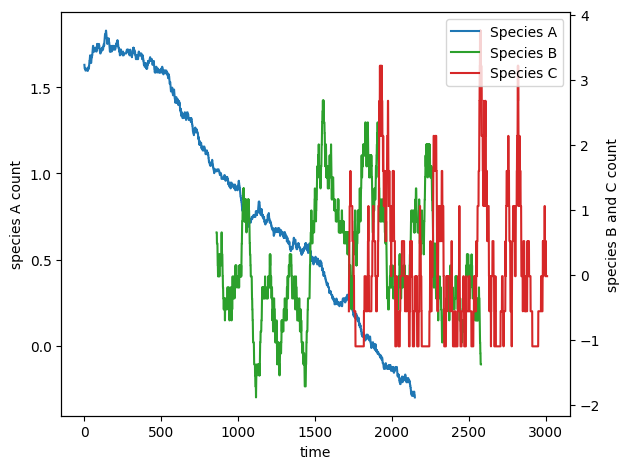

In [15]:
fig, ax1 = plt.subplots()

ax1.set_xlabel('time')
ax1.set_ylabel('species A count')
ax1.plot(species_0.y_0, label="Species A", color = 'tab:blue')
# ax1.legend(loc="upper right")

ax2 = ax1.twinx()

ax2.set_ylabel("species B and C count")
ax2.plot(species_1.y_1, label="Species B", color = 'tab:green')

# ax3 = ax1.twinx()
ax2.plot(species_2.y_2, label="Species C", color = 'tab:red')

fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
fig.tight_layout()
plt.show()

In [16]:
def split_window(features):
    input_slice = 3
    inputs = features[:, :input_slice, :]
    labels = features[:, input_slice:, -1:]

    return inputs, labels


def make_dataset(data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=4,
      sequence_stride=1,
      shuffle=False,
      batch_size=32,)
    
    ds = ds.map(split_window)
    
    return ds


train_generator_1 = make_dataset(species_0)
train_generator_2 = make_dataset(species_1)
train_generator_3 = make_dataset(species_2)


In [17]:
model  = MultiRNNTrainer([train_generator_1, train_generator_2, train_generator_3])


[<_MapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float32, name=None))>, <_MapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float32, name=None))>]


In [18]:
model.train(epochs=10)

Epoch0---Loss--------0.6261665225028992
Epoch1---Loss--------0.10150168091058731
Epoch2---Loss--------0.02306731976568699
Epoch3---Loss--------0.010010194964706898
Epoch4---Loss--------0.0038188400212675333
Epoch5---Loss--------0.002619631588459015
Epoch6---Loss--------0.0032697576098144054
Epoch7---Loss--------0.004078714642673731
Epoch8---Loss--------0.0044801807962358
Epoch9---Loss--------0.0044608572497963905
Epoch0---Loss--------0.5325551629066467
Epoch1---Loss--------0.23813195526599884
Epoch2---Loss--------0.1640918254852295
Epoch3---Loss--------0.15891171991825104
Epoch4---Loss--------0.15825533866882324
Epoch5---Loss--------0.1582016497850418
Epoch6---Loss--------0.158233180642128
Epoch7---Loss--------0.15826742351055145
Epoch8---Loss--------0.15829387307167053
Epoch9---Loss--------0.15830975770950317
Epoch0---Loss--------0.8279391527175903
Epoch1---Loss--------0.6355875730514526
Epoch2---Loss--------0.5225488543510437
Epoch3---Loss--------0.48473304510116577
Epoch4---Loss----

In [19]:
test_generator = make_dataset(species_2_test)
model_= model.models[-1]

pred = []
targ = []
for feat, target in test_generator:
    pred.append(np.array(model_.predict(feat)))
    targ.append(np.array(target))
    
pred = np.vstack(pred)
targ = np.vstack(targ)

1/1 [==============================] - 0s 174ms/step


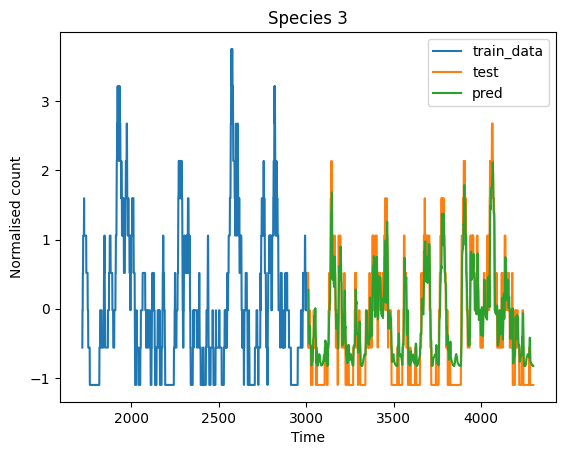

In [20]:
plt.plot(species_2["y_2"], label="train_data")
plt.plot(species_2_test.y_2, label="test")
plt.plot(species_2_test.index[3:], pred, label="pred")
plt.title("Species 3")
plt.xlabel("Time")
plt.ylabel("Normalised count")
plt.legend()
plt.show()
